In [138]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn import preprocessing

import warnings
warnings.filterwarnings('ignore')

# 1. read in data

In [147]:
train_df = pd.read_csv('./data/train.csv', index_col=0)
test_df = pd.read_csv('./data/test.csv', index_col=0)
test = pd.read_csv('./data/test.csv')

lowest_scored_thirty = lowest_scored_thirty = ['X344', 'X20','X117','X109','X378','X45','X362','X161','X164','X61',
 'X65','X380','X154', 'X300','X77', 'X114', 'X85', 'X321', 'X195','X209', 'X206', 'X283', 'X343', 'X340', 'X376',
 'X36', 'X375', 'X264', 'X250', 'X329',
 'X3', 'X0', 'X314', 'X350', 'X315', 'X180', 'X27', 'X261', 
 'X220', 'X321', 'X355', 'X29', 'X136',
# below are columns who only contains zeroes                                    
'X11', 'X93', 'X107', 'X233', 'X235', 'X268', 
'X289', 'X290', 'X293', 'X297', 'X330', 'X347']


train_df.drop(lowest_scored_thirty, axis=1)
test_df.drop(lowest_scored_thirty, axis=1)

train_df.head(8)

,y,X0,X1,X2,X3,X4,X5,X6,X8,X10,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
ID,,,,,,,,,,,,,,,,,,,,,
0,130.81,k,v,at,a,d,u,j,o,0,...,0,0,1,0,0,0,0,0,0,0
6,88.53,k,t,av,e,d,y,l,o,0,...,1,0,0,0,0,0,0,0,0,0
7,76.26,az,w,n,c,d,x,j,x,0,...,0,0,0,0,0,0,1,0,0,0
9,80.62,az,t,n,f,d,x,l,e,0,...,0,0,0,0,0,0,0,0,0,0
13,78.02,az,v,n,f,d,h,d,n,0,...,0,0,0,0,0,0,0,0,0,0
18,92.93,t,b,e,c,d,g,h,s,0,...,0,0,1,0,0,0,0,0,0,0
24,128.76,al,r,e,f,d,f,h,s,0,...,0,0,0,0,0,0,0,0,0,0
25,91.91,o,l,as,f,d,f,j,a,0,...,0,0,0,0,0,0,0,0,0,0


# 2. preprocess the data

## 2.1 rule out outliers

In [148]:
# modify the outlier of y who's larger than 180 to 180
# y_train = train_df["y"]
# y_mean = np.mean(y_train)

# y_ultimate = 180
# y_train.ix[y_train > y_ultimate] = y_ultimate

# plt.figure(figsize=(8,6))
# plt.scatter(range(y_train.shape[0]), np.sort(y_train))
# plt.show()

## 2.2 encode categoricals

In [149]:
for c in train_df.columns:
    if train_df[c].dtype == 'object':
        lbl = LabelEncoder() 
        lbl.fit(list(train_df[c].values) + list(test_df[c].values)) 
        train_df[c] = lbl.transform(list(train_df[c].values))
        test_df[c] = lbl.transform(list(test_df[c].values))
    
test_df.head(8)

,X0,X1,X2,X3,X4,X5,X6,X8,X10,X11,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
ID,,,,,,,,,,,,,,,,,,,,,
1,24,23,38,5,3,26,0,22,0,0,...,0,0,0,1,0,0,0,0,0,0
2,46,3,9,0,3,9,6,24,0,0,...,0,0,1,0,0,0,0,0,0,0
3,24,23,19,5,3,0,9,9,0,0,...,0,0,0,1,0,0,0,0,0,0
4,24,13,38,5,3,32,11,13,0,0,...,0,0,0,1,0,0,0,0,0,0
5,49,20,19,2,3,31,8,12,0,0,...,1,0,0,0,0,0,0,0,0,0
8,51,1,9,4,3,30,6,18,0,0,...,1,0,0,0,0,0,0,0,0,0
10,50,3,5,3,3,30,3,24,0,0,...,0,0,0,0,0,1,0,0,0,0
11,32,20,5,2,3,14,3,0,0,0,...,0,0,1,0,0,0,0,0,0,0


## 2.3 PCA/ICA

In [150]:
from sklearn.decomposition import PCA, FastICA
n_comp = 10

# PCA
pca = PCA(n_components=n_comp)
pca2_results_train = pca.fit_transform(train_df.drop(["y"], axis=1))
pca2_results_test = pca.transform(test_df)

# ICA
ica = FastICA(n_components=n_comp)
ica2_results_train = ica.fit_transform(train_df.drop(["y"], axis=1))
ica2_results_test = ica.transform(test_df)

# Append decomposition components to datasets
for i in range(1, n_comp+1):
    train_df['pca_' + str(i)] = pca2_results_train[:,i-1]
    test_df['pca_' + str(i)] = pca2_results_test[:, i-1]
    
    train_df['ica_' + str(i)] = ica2_results_train[:,i-1]
    test_df['ica_' + str(i)] = ica2_results_test[:, i-1]

train_df.head()

,y,X0,X1,X2,X3,X4,X5,X6,X8,X10,...,pca_6,ica_6,pca_7,ica_7,pca_8,ica_8,pca_9,ica_9,pca_10,ica_10
ID,,,,,,,,,,,,,,,,,,,,,
0,130.81,37,23,20,0,3,27,9,14,0,...,2.695534,0.015029,-3.821965,0.013099,1.536077,-0.026679,0.651194,-0.000950,1.731813,0.009539
6,88.53,37,21,22,4,3,31,11,14,0,...,4.442921,0.025405,0.792937,0.005794,0.819099,0.004888,0.795509,0.002250,-0.150112,0.004641
7,76.26,24,24,38,2,3,30,9,23,0,...,2.170449,0.016554,-0.864883,0.008528,1.589020,-0.007086,0.615186,-0.012471,-0.425316,-0.008384
9,80.62,24,21,38,5,3,30,11,4,0,...,4.299128,0.027168,2.193694,0.010400,2.111656,0.017143,-0.032776,-0.014976,-0.909016,-0.011510
13,78.02,24,23,38,5,3,14,3,13,0,...,-3.752398,-0.015702,1.917076,0.013948,2.112958,0.014384,-1.167528,-0.028514,-0.944696,-0.010849


In [151]:
# prepare the train x and train y
train_x = train_df.drop(["y"], axis = 1)
train_y = train_df["y"].values;

# 3. Prepare for regression

## 3.1 xgboost

[0]	train-rmse:95.9737	test-rmse:95.9725
[50]	train-rmse:10.7008	test-rmse:11.2333
[100]	train-rmse:6.66453	test-rmse:8.4636
[150]	train-rmse:5.85539	test-rmse:8.52943
105


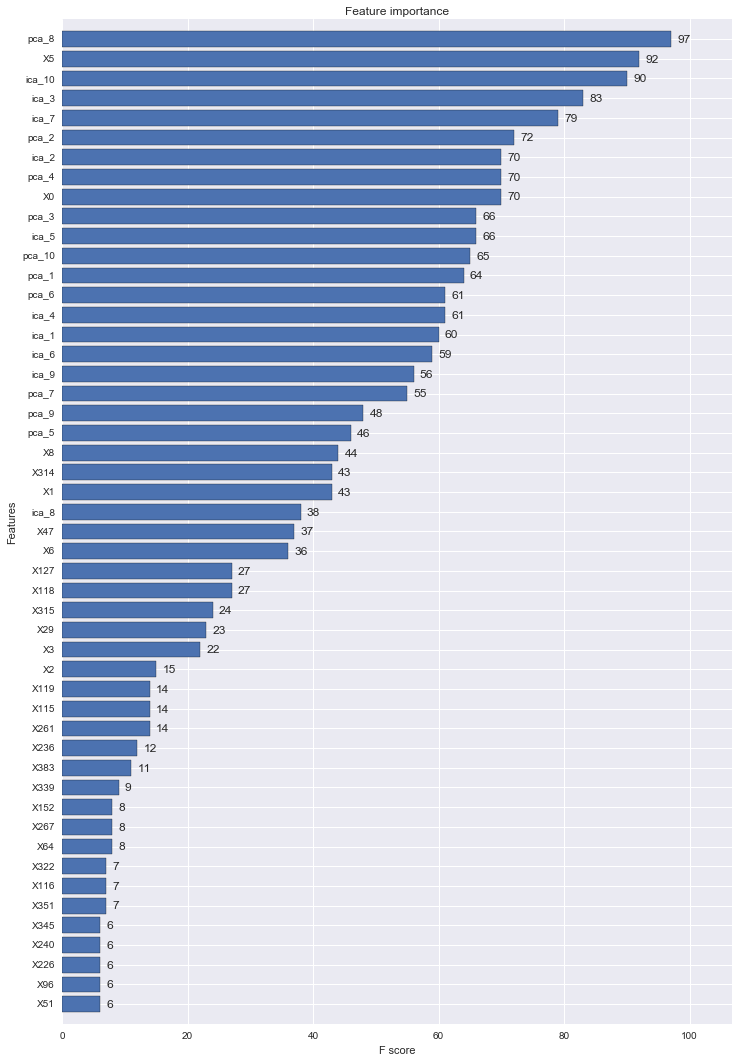

In [160]:
# Thanks to anokas for this #
def xgb_r2_score(preds, dtrain):
    labels = dtrain.get_label()
    return 'r2', r2_score(labels, preds)

xgb_params = {
    'eta': 0.05,
    'max_depth': 6,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'silent': 1
}

dtrain = xgb.DMatrix(train_x, train_y, feature_names=train_x.columns.values)

# xgboost, cross-validation
cv_result = xgb.cv(xgb_params, 
                   dtrain, 
                   num_boost_round=800,
                   early_stopping_rounds=50,
                   verbose_eval=50, 
                   show_stdv=False
                  )
num_boost_rounds = len(cv_result)
print(num_boost_rounds)

model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=100, feval=xgb_r2_score, maximize=True)

# plot the important features #
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

In [161]:
# check r2-score (to get higher score - increase num_boost_round in previous cell)
from sklearn.metrics import r2_score

# now fixed, correct calculation
r2_score = r2_score(dtrain.get_label(), model.predict(dtrain))
print(r2_score)

0.698120633959


In [162]:
# # make predictions and save results
# dtest = xgb.DMatrix(test_df)
# y_pred = model.predict(dtest)
# output = pd.DataFrame({'id': test["ID"], 'y': y_pred})
# output.to_csv('./result/xgboost-depth{}-pca-r2={}.csv'.format(xgb_params['max_depth'], r2_score), index=False)


## 3.2 random forest

In [164]:
from sklearn import ensemble
model = ensemble.RandomForestRegressor(n_estimators=200, max_depth=10, 
    min_samples_leaf=4, max_features=0.2, n_jobs=-1, random_state=0)
model.fit(train_x, train_y)
feat_names = train_x.columns.values

